In [1]:
!pip install ta
!pip install yfinance

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
from xgboost import plot_tree

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import yfinance as yf

In [3]:
start_date = "2017-01-01"
end_date = "2023-01-01"
symbol = "BTC-USD"
data = yf.download(symbol, start=start_date, end=end_date)
data = data[["Open", "High", "Low", "Close", "Volume"]]
df = data.copy()
df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000


In [4]:
df_fe = df.copy()
df_fe["Range"] = df_fe["High"] / df_fe["Low"] - 1
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

In [5]:
#df_fe.loc[df_fe["Close"].shift(-1) > df_fe["Close"], "TARGET"] = 1
#df_fe.loc[df_fe["Close"].shift(-1) <= df_fe["Close"], "TARGET"] = 0
df_fe.loc[df_fe["Range"].shift(-1) > df_fe["Avg_Range"], "TARGET"] = 1
df_fe.loc[df_fe["Range"].shift(-1) <= df_fe["Avg_Range"], "TARGET"] = 0

In [6]:
# Check for NaN
df_fe.dropna(inplace=True)
print(df_fe.isnull().values.any())

False


In [7]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2161 entries, 2017-01-30 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2161 non-null   float64
 1   High       2161 non-null   float64
 2   Low        2161 non-null   float64
 3   Close      2161 non-null   float64
 4   Volume     2161 non-null   int64  
 5   Range      2161 non-null   float64
 6   Avg_Range  2161 non-null   float64
 7   TARGET     2161 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 151.9 KB


In [8]:
df_fe.describe()

,Open,High,Low,Close,Volume,Range,Avg_Range,TARGET
count,2161.000000,2161.000000,2161.000000,2161.000000,2.161000e+03,2161.000000,2161.000000,2161.000000
mean,17837.307978,18288.632085,17331.657050,17842.476625,2.287211e+10,0.053166,0.053327,0.361407
std,16750.722369,17179.823911,16249.280571,16742.604834,2.025297e+10,0.044548,0.024174,0.480519
min,920.151001,923.047974,903.713013,920.382019,6.753000e+07,0.003887,0.015818,0.000000
25%,6486.250000,6592.490234,6395.950195,6489.189941,5.551400e+09,0.025525,0.036296,0.000000
50%,9729.321289,9938.297852,9539.624023,9743.860352,2.022419e+10,0.041590,0.048019,0.000000
75%,23948.345703,24572.580078,23580.507812,23947.642578,3.343038e+10,0.064993,0.064761,1.000000
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.631387,0.138628,1.000000


# Train Test Split

In [9]:
# Remove unwanted columns
df_tts = df_fe.copy()
df_tts.drop(columns=["Close","Open", "High", "Low"], inplace=True)

In [10]:
# Split into Learning (X) and Target (y) Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [11]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (1728, 3)
Shape of y_train:  (1728,)


# Build Initial Model

In [12]:
#Metrics
objective = "binary:logistic"
eval_metric = "aucpr"
scoring = "precision"

In [13]:
# Build First Classifier Model 0
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

# Find Hyperparameters

In [14]:
# Provide Gris for Hyperparams
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [15]:
# Perform Random Search for Best Hyper params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >>", f"ne: {ne},", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Recommended Params >> ne: 65, lr: 0.05 md: 2 gm: 6


# Train Model

In [16]:
# Build Classification Model 1
classifier_1 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [17]:
# Fit Model
eval_set = [(X_train, y_train)]
classifier_1.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=6,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=65, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

# Make Predictions

In [18]:
# Get Predictions Training
train_yhat = classifier_1.predict(X_train)

In [19]:
# Get Predictions Test
test_yhat = classifier_1.predict(X_test)

In [20]:
#Accuracy Training and Test
print("Train Accuracy: ", accuracy_score(y_train, train_yhat))
print("Test Accuracy: ", accuracy_score(y_test, test_yhat))

Train Accuracy:  0.6822916666666666
Test Accuracy:  0.6697459584295612


In [21]:
# Summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      1104
         1.0       0.76      0.18      0.29       624

    accuracy                           0.68      1728
   macro avg       0.72      0.57      0.54      1728
weighted avg       0.71      0.68      0.61      1728



In [22]:
# Summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.67      0.97      0.79       276
         1.0       0.73      0.14      0.24       157

    accuracy                           0.67       433
   macro avg       0.70      0.56      0.51       433
weighted avg       0.69      0.67      0.59       433



#Confusion Matrix



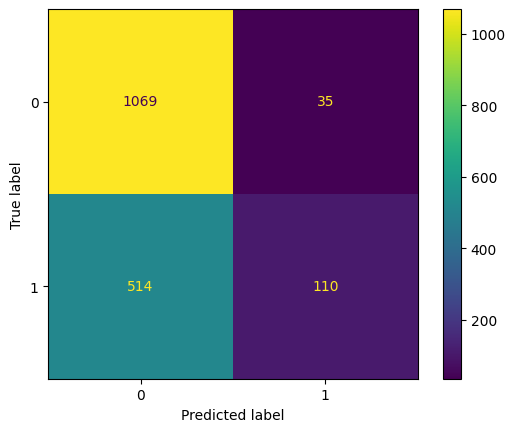

In [23]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

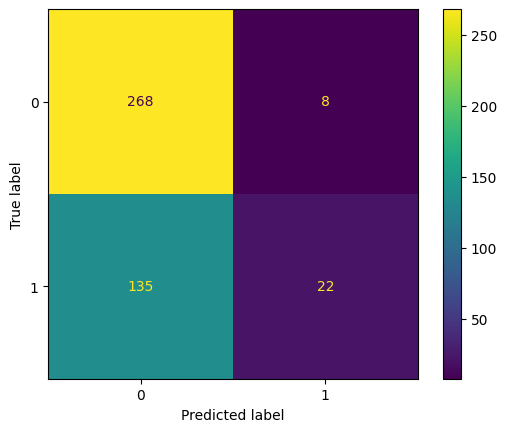

In [24]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

# XGBOOST TREE

<Axes: >

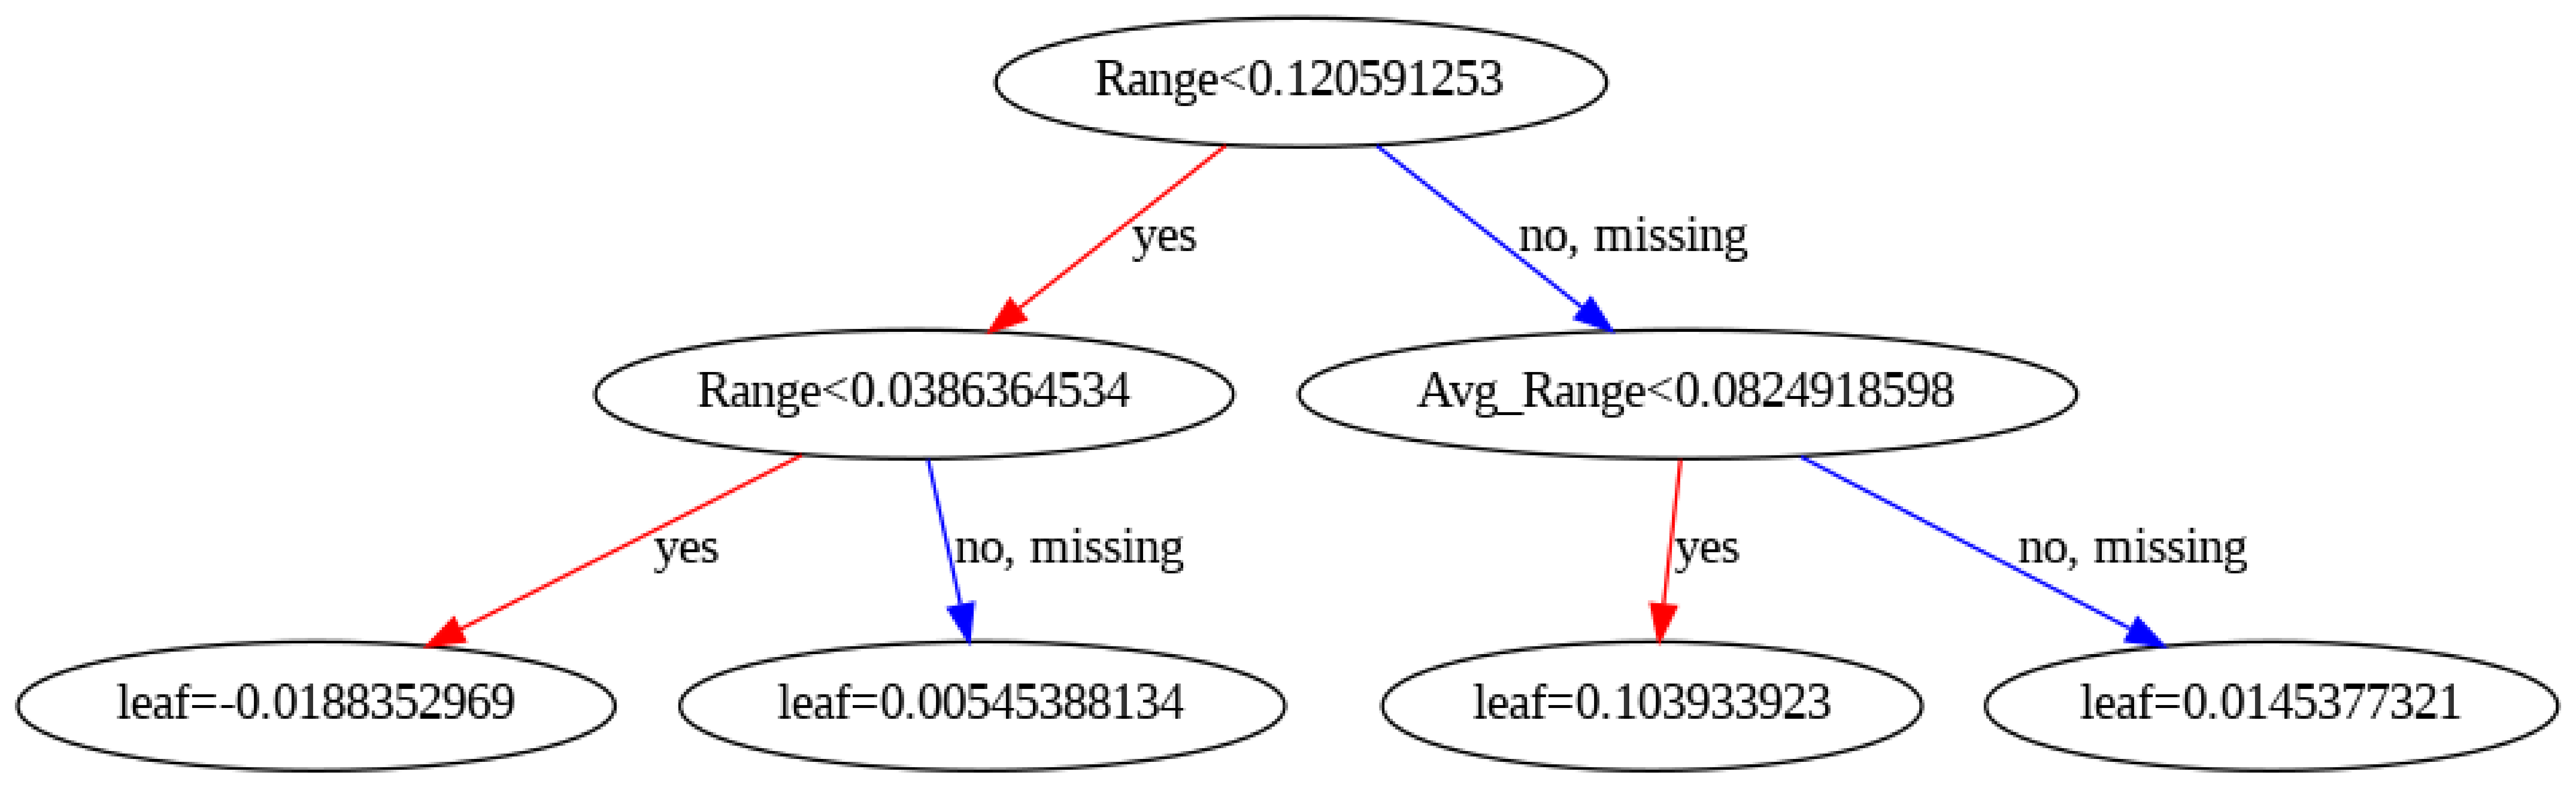

In [25]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier_1)